<a href="https://colab.research.google.com/github/ML77777/EC_2018_grp17/blob/master/NLP1_prac1_21november.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practical 1: Sentiment Detection of Movie Reviews
========================================



This practical concerns sentiment detection of movie reviews.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task (how might one go about classifying the texts?); you will write
code that decides whether a random unseen movie review is positive or
negative.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. were the "inventors" of the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Bo Pang’s system. If you have questions about it,
we should resolve them in our first demonstrated practical.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

**Environment**

All code should be written in **Python 3**. 
If you use Colab, check if you have that version with `Runtime -> Change runtime type` in the top menu.

> If you want to work in your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.

#### Learning Python 3

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

Loading the Data
-------------------------------------------------------------

In [1]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

--2018-11-21 19:22:25--  https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662577 (647K) [text/plain]
Saving to: ‘sent_lexicon’

sent_lexicon        100%[===================>] 647.05K  --.-KB/s    in 0.06s   

2018-11-21 19:22:25 (10.3 MB/s) - ‘sent_lexicon’ saved [662577/662577]

--2018-11-21 19:22:26--  https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|151

In [0]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# load reviews into memory
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.

# For documentation on POS-tags, see 
# https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf

with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print(len(reviews))

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("#types", len(c))

print("Most common tokens:")
for token, count in c.most_common(25):
  print("%10s : %8d" % (token, count))
  

2000
0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.
#types 47743
Most common tokens:
       

Symbolic approach – sentiment lexicon (2pts)
---------------------------------------------------------------------



**How** could one automatically classify movie reviews according to their
sentiment? 

If we had access to a **sentiment lexicon**, then there are ways to solve
the problem without using Machine Learning. One might simply look up
every open-class word in the lexicon, and compute a binary score
$S_{binary}$ by counting how many words match either a positive, or a
negative word entry in the sentiment lexicon $SLex$.

$$S_{binary}(w_1w_2...w_n) = \sum_{i = 1}^{n}\text{sgn}(SLex\big[w_i\big])$$

**Threshold.** In average there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1w_2...w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{else }
        \end{array}
$$

To implement this approach, you should use the sentiment
lexicon in `sent_lexicon`, which was taken from the
following work:

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

#### (Q: 1.1) Implement this approach and report its classification accuracy. (1 pt)

In [152]:
# YOUR CODE HERE
slex = open("sent_lexicon","r").readlines()

def create_lookup(slex):
    lookup_table = {}
    #distinct_pos_tags = []
    for i in slex:
        dict_element = i.split()
        word = dict_element[2].split("=")[1]
        pos_tag = dict_element[3].split("=")[1]
        polarity =  dict_element[5].split("=")[1]
        #lookup_table[(word,pos_tag)] = polarity
        lookup_table[word] = polarity
        #if pos_tag not in distinct_pos_tags:
        #    distinct_pos_tags.append(pos_tag) #Possible tags in lexicon are, adj (JJ), noun (NN), adverb (RB) and anypos
    
    return lookup_table

def predict_review_binary(lookup_table,list_sentences):
    result = "NEG"
    sentiment_score = 0
    for sentence in list_sentences:
        for token,pos_tag in sentence:
            #print(token,pos_tag)
            if "JJ" in pos_tag:
                pos_tag_key = "adj"
            elif "NN" in pos_tag:
                pos_tag_key = "noun"
            elif "RB" in pos_tag:
                pos_tag_key = "adverb"
            else: pos_tag_key = "anypos"
            #key = (token,pos_tag_key) #64.05 accuracy
            #key = (token.lower(),pos_tag_key) #62.9 accuracy
            #key = token.lower() #67.75 accuracy
            key = token #67.95 accuracy
            if key in lookup_table:
                polarity = lookup_table[key]
                if polarity == "positive":
                    sentiment_score += 1
                elif polarity == "negative":
                    sentiment_score -= 1
    if sentiment_score > 8:
        result = "POS"
    #print("Sentiment score: {}".format(sentiment_score))
    return result

def get_binary_results(lookup_table, reviews):
    targets = []
    predictions = []
    correctness_predictions = []
    for review in reviews: 
        prediction = predict_review_binary(lookup_table,review["content"])
        predictions.append(prediction)
        target = review["sentiment"]
        targets.append(target)
        if prediction == target:
            correctness_predictions.append("+")
        else: correctness_predictions.append("-")
    return (predictions,targets,correctness_predictions)

def calc_accuracy(predictions,targets):
    amount_correct = 0
    amount_reviews = len(targets)

    for i in range(amount_reviews):
        prediction = predictions[i]
        target = targets[i]
        if prediction == target:
            amount_correct += 1
    accuracy = amount_correct/amount_reviews #* 100
    return accuracy

lookup_table = create_lookup(slex) 
predictions,targets,correctness_results = get_binary_results(lookup_table,reviews)
accuracy = calc_accuracy(predictions,targets)
print("Accuracy: {}".format(accuracy))

Accuracy: 0.6795


In [5]:
token_results = correctness_results # Correctness of sentiment predictons against the actual targets
token_accuracy = accuracy # 67.95 for just comparing words, taking pos_tag into account drops to 64 or 62%
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 67.95


If the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* would have higher magnitude than
*“good"*), we could take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Their lexicon also records two possible magnitudes of sentiment (*weak*
and *strong*), so you can implement both the binary and the weighted
solutions (please use a switch in your program). For the weighted
solution, you can choose the weights intuitively *once* before running
the experiment.

#### (Q: 1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1 pt)

In [6]:
# YOUR CODE HERE
def create_lookup_extension(slex,weighted=False):
    lookup_table = {}
    #distinct_pos_tags = []
    for i in slex:
        dict_element = i.split()
        word = dict_element[2].split("=")[1]
        pos_tag = dict_element[3].split("=")[1]
        polarity =  dict_element[5].split("=")[1]
        #lookup_table[(word,pos_tag)] = polarity
        #Extension for weighted solution
        if weighted:
            type_subj = dict_element[0].split("=")[1]
            lookup_table[word] = (polarity,type_subj)
        else: 
            lookup_table[word] = polarity
        #if pos_tag not in distinct_pos_tags:
        #    distinct_pos_tags.append(pos_tag) #Possible tags in lexicon are, adj (JJ), noun (NN), adverb (RB) and anypos
    
    return lookup_table

def predict_review_weighted(lookup_table,list_sentences, weight_argument):
    result = "NEG"
    sentiment_score = 0
    for sentence in list_sentences:
        for token,pos_tag in sentence:
            key = token 
            if key in lookup_table:
                polarity,type_subj = lookup_table[key]
                if type_subj == "weaksubj":
                    weight = 1
                else: weight = weight_argument
                    
                if polarity == "positive":
                    sentiment_score += 1 * weight
                elif polarity == "negative":
                    sentiment_score -= 1 * weight
    if sentiment_score > 8:
        result = "POS"
    #print("Sentiment score: {}".format(sentiment_score))
    return result

def get_weighted_results(lookup_table,reviews,weight):
    targets = []
    predictions = []
    correctness_predictions = []
    for review in reviews: 
        prediction = predict_review_weighted(lookup_table,review["content"],weight)
        predictions.append(prediction)
        target = review["sentiment"]
        targets.append(target)
        if prediction == target:
            correctness_predictions.append("+")
        else: correctness_predictions.append("-")
            
    return (predictions,targets,correctness_predictions)

def run_binary_predictions(sent_lexicon,document_set):
    lookup_table = create_lookup_extension(sent_lexicon,False)
    binary_predictions,targets,correctness_results = get_binary_results(lookup_table,document_set)
    binary_accuracy = calc_accuracy(binary_predictions,targets)
    return (binary_predictions,binary_accuracy,correctness_results)

def run_weighted_predictions(sent_lexicon,document_set,weight):
    lookup_table = create_lookup_extension(sent_lexicon,True)
    weighted_predictions,targets,correctness_results = get_weighted_results(lookup_table,document_set,weight)
    weighted_accuracy = calc_accuracy(weighted_predictions,targets)
    return (weighted_predictions,weighted_accuracy,correctness_results)

def predict_binary_or_weighted(sent_lexicon=slex,document_set=reviews,prediction_type="B",given_weight=4):
    switcher = {
        "B":run_binary_predictions(sent_lexicon,document_set),
        "W":run_weighted_predictions(sent_lexicon,document_set,given_weight)
    }
    return switcher.get(prediction_type, ([],0)) #Returns predictions and accuracy
    
weighted_predictions, weighted_accuracy, weighted_correctness = predict_binary_or_weighted(slex,reviews,"W",4)
binary_predictions, binary_accuracy,binary_correctness = predict_binary_or_weighted(slex,reviews,"B")
print("Weighted Accuracy: {}%".format(weighted_accuracy))
print("Binary Accuracy: {}%".format(binary_accuracy))

Weighted Accuracy: 68.45%
Binary Accuracy: 67.95%


In [7]:
magnitude_results = weighted_correctness  # Correctness of sentiment predictons against the actual targets
magnitude_accuracy = weighted_accuracy# 68.45%
print("Accuracy: %0.2f" % magnitude_accuracy)

Accuracy: 68.45


#### Optional: make a barplot of the two results.

In [0]:
# YOUR CODE HERE

Answering questions in statistically significant ways (1pt)
-------------------------------------------------------------

Does using the magnitude improve the results? Oftentimes, answering questions like this about the performance of
different signals and/or algorithms by simply looking at the output
numbers is not enough. When dealing with natural language or human
ratings, it’s safe to assume that there are infinitely many possible
instances that could be used for training and testing, of which the ones
we actually train and test on are a tiny sample. Thus, it is possible
that observed differences in the reported performance are really just
noise. 

There exist statistical methods which can be used to check for
consistency (*statistical significance*) in the results, and one of the
simplest such tests is the **sign test**. 

The sign test is based on the binomial distribution. Count all cases when System 1 is better than System 2, when System 2 is better than System 1, and when they are the same. Call these numbers $Plus$, $Minus$ and $Null$ respectively. 

The sign test returns the probability that the null hypothesis is true. 

This probability is called the $p$-value and it can be calculated for the two-sided sign test using the following formula (we multiply by two because this is a two-sided sign test and tests for the significance of differences in either direction):

$$2 \, \sum\limits_{i=0}^{k} \binom{N}{i} \, q^i \, (1-q)^{N-i}$$

where $$N = 2 \Big\lceil \frac{Null}{2}\Big\rceil + Plus + Minus$$ is the total
number of cases, and
$$k = \Big\lceil \frac{Null}{2}\Big\rceil + \min\{Plus,Minus\}$$ is the number of
cases with the less common sign. 

In this experiment, $q = 0.5$. Here, we
treat ties by adding half a point to either side, rounding up to the
nearest integer if necessary. 


#### (Q 2.1): Implement the sign test. Is the difference between the two symbolic systems significant? What is the p-value? (1 pt)

You should use the `comb` function from `scipy` and the `decimal` package for the stable adding of numbers in the final summation.

You can quickly verify the correctness of
your sign test code using a [free online
tool](https://www.graphpad.com/quickcalcs/binomial1.cfm).

In [9]:
from decimal import Decimal
from scipy.special import comb


def sign_test(results_1, results_2):
  """test for significance
  results_1 is a list of classification results (+ for correct, - incorrect)
  results_2 is a list of classification results (+ for correct, - incorrect)
  """
  ties, plus, minus = 0, 0, 0

  # "-" carries the error
  for i in range(0, len(results_1)):
    if results_1[i]==results_2[i]:
      ties += 1
    elif results_1[i]=="-": 
      plus += 1
    elif results_2[i]=="-": 
      minus += 1

  n = 2 * (ties/2) + plus + minus
  k = (ties/2) + min([plus,minus])

  summation = Decimal(0.0)
  for i in range(0,int(k)+1):
      summation += Decimal(comb(n, i,True)) # YOUR CODE HERE

  # use two-tailed version of test
  summation *= 2
  summation *= (Decimal(0.5)**Decimal(n))
  
  print("the difference is", 
        "not significant" if summation >= 0.05 else "significant")
  
  return summation

p_value = sign_test(token_results, magnitude_results)
print("p_value =", p_value)

the difference is not significant
p_value = 0.8405124276655436267484850072


## Using the Sign test

**From now on, report all differences between systems using the
sign test.** You can think about a change that you apply to one system, as a
 new system.
    
You should report statistical test
results in an appropriate form – if there are several different methods
(i.e., systems) to compare, tests can only be applied to pairs of them
at a time. This creates a triangular matrix of test results in the
general case. When reporting these pair-wise differences, you should
summarise trends to avoid redundancy.


Naive Bayes (8pt + 1pt bonus)
==========


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described in Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing text information as vectors (or points in space), making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text.

## Writing your own classifier

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you a position to replicate
    Pang et al., Naive Bayes results. However, the numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. You will find the
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, and store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.

#### (Q3.1) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining reviews cv900–cv999.  Report results using simple classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [150]:
# YOUR CODE HERE
#Current duration 66 seconds, see if it can be reduced

from math import log
from random import randint

class NB_classifier():
 
  def fit(self,classes,documents):
    self.amount_docs = len(documents)
    self.amount_doc_per_class = [0 for i in range(len(classes))] #Amount POS (class) documents is index 0 and NEG is index 1
    self.prior_of_classes = [0.0 for i in range(len(classes))] 
    self.classes = classes
    self.total_vocabulary = set()
    self.class_word_counters = [Counter(),Counter()]
    self.total_amount_words_class = [0 for i in range(len(classes))]
    print(classes)
    
    for review in documents:
      sentiment = review["sentiment"]
      content = review["content"]
      if sentiment == classes[0]: #Positive class
        self.amount_doc_per_class[0] +=1
        class_index = 0
      else: #Negative class
        self.amount_doc_per_class[1] +=1
        class_index = 1

      for sentence in content:
        for token,pos_tag in sentence:
          token = token.lower()
          if token not in self.total_vocabulary:
            self.total_vocabulary.add(token) 
           
          counter_dict = self.class_word_counters[class_index]
          counter_dict[token]  += 1
          self.total_amount_words_class[class_index] += 1
    
    self.prior_of_classes[0] = self.amount_doc_per_class[0] / self.amount_docs
    self.prior_of_classes[1] = self.amount_doc_per_class[1] / self.amount_docs
    #print(" Total amount pos in dict {}".format(self.total_amount_words_class[0]))
    #print(" Total amount neg in dict {}".format(self.total_amount_words_class[1]))
   
    
  def predict(self,test_documents):
      pos_prior = log(self.prior_of_classes[0]) if self.prior_of_classes[0] > 0 else 0
      neg_prior = log(self.prior_of_classes[1]) if self.prior_of_classes[1] > 0 else 0
      predictions = []
      targets = []
      pos_dict = self.class_word_counters[0]
      neg_dict = self.class_word_counters[1]
      
      for review in test_documents:
        targets.append(review["sentiment"])
        content = review["content"]
        probability_POS = pos_prior
        probability_NEG = neg_prior
        total_conditional_pos = 0
        total_conditional_neg = 0 
        
        for sentence in content:
          for token,pos_tag in sentence:
            token = token.lower()
            if token in self.total_vocabulary:
              occ_in_pos =  pos_dict.get(token)
              occ_in_neg = neg_dict.get(token)

              if occ_in_pos != None:
                #print("Word {} and occ {}".format(token,occ_in_pos))
                conditional_pos = occ_in_pos / self.total_amount_words_class[0]
                total_conditional_pos += log(conditional_pos)
              if occ_in_neg != None:
                #print("Word {} and occ {}".format(token,occ_in_neg))
                conditional_neg = occ_in_neg / self.total_amount_words_class[1]
                total_conditional_neg += log(conditional_neg)
                
        probability_POS += total_conditional_pos
        probability_NEG += total_conditional_neg
        probs = [probability_POS,probability_NEG]
        max_prob = max(probs)
        count = probs.count(max_prob)
        if count == 1:
          max_index = probs.index(max_prob)
        else: max_index = randint(0, 1)
        predictions.append(self.classes[max_index])
        
      return (predictions,targets)
    
  def get_correctness_results(self,predictions,targets):
    correctness_predictions = []
    for i,prediction in enumerate(predictions):
      target = targets[i]
      if (prediction == target):
        correctness_predictions.append("+")
      else:
        correctness_predictions.append("-")
    return correctness_predictions
  

classes = ["POS","NEG"]
neg_reviews =  reviews[0:1000]
pos_reviews = reviews[1000:]
train_set = neg_reviews[:900] + pos_reviews[:900]
test_set = neg_reviews[900:] + pos_reviews[900:]
print(len(train_set))
print(len(test_set))

nb = NB_classifier()
nb.fit(classes,train_set)
predictions,targets = nb.predict(test_set)
acc = calc_accuracy(predictions,targets)
no_smoothing_results = nb.get_correctness_results(predictions,targets)
print(predictions)
print(targets)
print("Accuracy of no smoothing: {}%".format(acc))

1800
200
['POS', 'NEG']
['POS', 'NEG', 'NEG', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'POS', 'POS', 'NEG', 'POS', 'POS', 'NEG', 'NEG', 'POS', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'POS', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'POS', 'NEG', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'P

#### (Bonus Questions) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

You can simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

In [0]:
# YOUR CODE HERE
#Same as above, but rreplace train and test set with:
train_set = neg_reviews[:90] + pos_reviews[:900]
test_set = neg_reviews[900:910] + pos_reviews[900:]
#Accuracy would not be a good measure, since there is dominance of a class in training and test set (class inbalance). 
#Therefore a classifier could just predict one class all the time and still achieve an high accuracy if that class is dominating in the test set.
#It then would not really be a classifier anymore if just predicts one class the whole time, and is not able to distinguish between them
#Thus, other measures that would be helpfull are precision and recall that also take False positive or false negatives into account. In this case, recall is probably more desired as positive reviews are dominating in test set.

## Smoothing

The presence of words in the test dataset that
haven’t been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q3.2) Implement Laplace feature smoothing (1pt)
($smoothing(\cdot) = \kappa$, constant for all words) in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [66]:
# YOUR CODE HERE Same, as before, but with smoothing function

from math import log
from random import randint
from nltk.stem.porter import *
stemmer = PorterStemmer()

class NB_classifier():
  
  def __init__(self,classes,smoothing_value=0,tostem=False):
    self.smoothing_value = smoothing_value
    self.tostem = tostem
    self.classes = classes

  def fit(self,documents):
    self.amount_docs = len(documents)
    self.amount_doc_per_class = [0] * len(classes) #Amount POS (class) documents is index 0 and NEG is index 1
    self.prior_of_classes = [0.0] * len(classes) 
    self.total_vocabulary = set()
    self.class_word_counters = [Counter(),Counter()]
    self.total_amount_words_class = [0] * len(classes)

    for review in documents:
      sentiment = review["sentiment"]
      content = review["content"]
      
      if sentiment == classes[0]: #Positive class
        self.amount_doc_per_class[0] +=1
        class_index = 0
      else: #Negative class
        self.amount_doc_per_class[1] +=1
        class_index = 1

      for sentence in content:
        for token,pos_tag in sentence:
          token = token.lower()
          if self.tostem:
             token = stemmer.stem(token)
          if token not in self.total_vocabulary:
            self.total_vocabulary.add(token) 
           
          counter_dict = self.class_word_counters[class_index]
          counter_dict[token]  += 1
          self.total_amount_words_class[class_index] += 1
    
    self.prior_of_classes[0] = self.amount_doc_per_class[0] / self.amount_docs
    self.prior_of_classes[1] = self.amount_doc_per_class[1] / self.amount_docs
    #print(" Total amount pos in dict {}".format(self.total_amount_words_class[0]))
    #print(" Total amount neg in dict {}".format(self.total_amount_words_class[1]))
   
    
  def predict(self,test_documents):
      pos_prior = log(self.prior_of_classes[0]) if self.prior_of_classes[0] > 0 else 0
      neg_prior = log(self.prior_of_classes[1]) if self.prior_of_classes[1] > 0 else 0
      predictions = []
      pos_dict = self.class_word_counters[0]
      neg_dict = self.class_word_counters[1]
      
      for review in test_documents:
        content = review["content"]
        probability_POS = pos_prior
        probability_NEG = neg_prior
        total_conditional_pos = 0
        total_conditional_neg = 0 
        
        for sentence in content:
          for token,pos_tag in sentence:
            token = token.lower()
            if self.tostem:
                token = stemmer.stem(token)
            if token in self.total_vocabulary:
              occ_in_pos = pos_dict[token] if token in self.class_word_counters[0] else 0
              occ_in_neg = neg_dict[token] if token in self.class_word_counters[1] else 0

              #Added change for smoothing, occ_in_pos and occ_in_neg = 0 initial and add smoothing by conditional
              if self.smoothing_value > 0:
                  conditional_pos = (occ_in_pos + self.smoothing_value) / (self.total_amount_words_class[0] + len(self.total_vocabulary) * self.smoothing_value)
                  conditional_neg = (occ_in_neg + self.smoothing_value) / (self.total_amount_words_class[1] + len(self.total_vocabulary) * self.smoothing_value)
              else: 
                  conditional_pos = occ_in_pos / self.total_amount_words_class[0]
                  conditional_neg = occ_in_neg / self.total_amount_words_class[1]
              total_conditional_pos += log(conditional_pos)
              total_conditional_neg += log(conditional_neg)
                
        probability_POS += total_conditional_pos
        probability_NEG += total_conditional_neg
        probs = [probability_POS,probability_NEG]
        max_prob = max(probs)
        count = probs.count(max_prob)
        if count == 1:
          max_index = probs.index(max_prob)
        else: max_index = randint(0, 1)
        predictions.append(self.classes[max_index])
        
      return predictions
    
def get_correctness_results(predictions,targets):
    correctness_predictions = []
      
    for i,prediction in enumerate(predictions):
      target = targets[i]
      if (prediction == target):
         correctness_predictions.append("+")
      else:
         correctness_predictions.append("-")
        
    return correctness_predictions
    

classes = ["POS","NEG"]
neg_reviews =  reviews[0:1000]
pos_reviews = reviews[1000:]
train_set = neg_reviews[:900] + pos_reviews[:900]
test_set = neg_reviews[900:] + pos_reviews[900:]
print(len(train_set))
print(len(test_set))

nb = NB_classifier(classes,1)
nb.fit(train_set)
smoothing_predictions = nb.predict(test_set)
targets = []
for review in test_set:
    targets.append(review["sentiment"])

acc = calc_accuracy(smoothing_predictions,targets)
smoothing_results = get_correctness_results(smoothing_predictions,targets)
print(predictions)
print(targets)
print("Accuracy of smoothing: {}%".format(acc))


1800
200
['POS', 'NEG', 'NEG', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'POS', 'POS', 'NEG', 'POS', 'POS', 'NEG', 'NEG', 'POS', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'POS', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'POS', 'NEG', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'POS', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'POS', 'NEG', 'NEG', 'POS', 'NEG', 'NEG', 'NEG', 'NEG', 'NEG', 'POS', 'NEG', 'NE

#### (Q3.3) Is the difference between non smoothed (Q3.1) and smoothed (Q3.2) statistically significant? (0.5pt)

In [53]:

#Different is statiscally significant
p_value = sign_test(no_smoothing_results, smoothing_results)
print("p_value =", p_value)

the difference is significant
p_value = 0.000003547178174130642586494974890


## Cross-validation

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is that we
end up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that’s better
and better on our data, but worse and worse at generalizing to new,
never-before seen data.

A simple method to guard against Type III errors is to use
cross-validation. In N-fold cross-validation, we divide the data into N
distinct chunks / folds. Then, we repeat the experiment N times, each
time holding out one of the chunks for testing, training our classifier
on the remaining N - 1 data chunks, and reporting performance on the
held-out chunk. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)

#### (Q3.4) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q3.2 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)






In [123]:
# YOUR CODE HERE
#Takes a while

#Create folds according to the round-robin (mod 10) as that is the amount of folds
def create_folds(data,amount_folds):
  all_folds = [[] for i in range(amount_folds)]
  review_index = 0
  while review_index < len(data):
    for i,fold in enumerate(all_folds):
        review = data[review_index + i]
        fold.append(review)
    review_index += amount_folds
   
  return all_folds

def cross_validation(classifier,data,amount_folds,preprocessing=False,include_pos_tag=False,vocabulary=None,preference_pos=False):
    all_folds = create_folds(reviews,10)
    folds_performance = []
    correctness_results = []
    
    for i,test_fold in enumerate(all_folds):
      training_set = []
      for j in range(10):
        if i != j:
          training_fold = all_folds[j]
          training_set += training_fold
         
      if preprocessing: #Preprocessing training and test data for SVM
        features,train_targets,voc = get_FeaturesAndTargets(training_set,include_pos_tag,vocabulary,preference_pos)
        x_train = features
        y_train = train_targets
        classifier.fit(x_train,y_train)

        x_test,y_test,voc = get_FeaturesAndTargets(test_fold,include_pos_tag,voc,preference_pos)
        targets = y_test
        predictions = classifier.predict(x_test)
        
      else:
        targets = []
        for review in test_fold:
           targets.append(review["sentiment"])

        classifier.fit(training_set) #Classifier training resets
        predictions = classifier.predict(test_fold)
        
      acc = calc_accuracy(predictions,targets)
      print("Accuracy of fold {}: {}".format(i+1,acc))
      folds_performance.append(acc)
      results = get_correctness_results(predictions,targets)
      correctness_results += results
    
    sum_acc = sum(folds_performance)
    mean_acc = sum_acc/amount_folds
    print("Final performance average: {}".format(mean_acc))
    
    return (folds_performance,mean_acc,correctness_results)
  
nb = NB_classifier(classes,1)
folds_performance, mean_acc,smoothing_cv_results = cross_validation(nb,reviews,10)




Accuracy of fold 1: 79.0
Accuracy of fold 2: 83.5
Accuracy of fold 3: 80.5
Accuracy of fold 4: 82.5
Accuracy of fold 5: 78.0
Accuracy of fold 6: 84.5
Accuracy of fold 7: 83.0
Accuracy of fold 8: 77.5
Accuracy of fold 9: 83.0
Accuracy of fold 10: 84.0
Final performance average: 81.55


#### (Q3.5) Write code to calculate and report variance, in addition to the final performance. (1pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [103]:
# YOUR CODE HERE
print(folds_performance)
array = np.array(folds_performance)
var = np.var(array)
print("Variance: {}".format(var))


[79.0, 83.5, 80.5, 82.5, 78.0, 84.5, 83.0, 77.5, 83.0, 84.0]
Variance: 6.0225


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

#### (Q3.6): A touch of linguistics (1pt)

Taking a step further, you can use stemming to
hash different inflections of a word to the same feature in the BoW
vector space. How does the performance of your classifier change when
you use stemming on your training and test datasets? Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.
 Also, you should do cross validation and concatenate the predictions from all folds to compute the significance.

In [57]:
# YOUR CODE HERE
nb = NB_classifier(classes,1,True)
stem_folds_performance, stem_mean_acc, stem_cv_results = cross_validation(nb,reviews,10)
#The performance does not change too much in terms of accuracy,but execution time is increased due to the overhead of stemming. 



Accuracy of fold 1: 78.0
Accuracy of fold 2: 84.0
Accuracy of fold 3: 80.5
Accuracy of fold 4: 84.0
Accuracy of fold 5: 77.5
Accuracy of fold 6: 84.0
Accuracy of fold 7: 82.0
Accuracy of fold 8: 77.5
Accuracy of fold 9: 83.0
Accuracy of fold 10: 83.0
Final performance average: 81.35


#### (Q3.7): Is the difference between NB with smoothing and NB with smoothing+stemming significant? (0.5pt)


In [71]:
# No it is not significant
p_value = sign_test(smoothing_cv_results, stem_cv_results)
print("p_value =", p_value)

the difference is not significant
p_value = 0.9465186089423488346539016590


#### Q3.8: What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q3.2)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [60]:
classes = ["POS","NEG"]
neg_reviews =  reviews[0:1000]
pos_reviews = reviews[1000:]
train_set = neg_reviews[:900] + pos_reviews[:900]

nb = NB_classifier(classes)
nb.fit(train_set)
print("Size of vocabulary without stemming: {}".format( len(nb.total_vocabulary) ))

nb = NB_classifier(classes,1,True)
nb.fit(train_set)
print("Size of vocabulary with stemming: {}".format( len(nb.total_vocabulary) ))

#The number of features decreases with stemming, which makes sense as many words can be simplified to the same canonical form. Therefore, 5 features can become 1 feature for example. 

Size of vocabulary without stemming: 45348
Size of vocabulary with stemming: 32404


#### Q3.9: Putting some word order back in (0.5+0.5pt=1pt)

A simple way of retaining some of the word
order information when using bag-of-words representations is to add **n-grams** features. 
Retrain your classifier from (Q3.4) using **unigrams+bigrams** and
**unigrams+bigrams+trigrams** as features, and report accuracy and statistical significances (in comparison to the experiment at (Q3.4) for all 10 folds, and between the new systems).





In [119]:
# 
from math import log
from random import randint
from nltk.stem.porter import *
stemmer = PorterStemmer()

class NB_classifier():
  
  def __init__(self,classes,smoothing_value=0,tostem=False,uni_bi_or_trigram=1):
    self.smoothing_value = smoothing_value
    self.tostem = tostem
    self.classes = classes
    self.uni_bi_or_trigram = uni_bi_or_trigram

  def fit(self,documents):
    self.amount_docs = len(documents)
    self.amount_doc_per_class = [0] * len(classes) #Amount POS (class) documents is index 0 and NEG is index 1
    self.prior_of_classes = [0.0] * len(classes) 
    self.class_word_counters_unigram = [Counter(),Counter()]
    self.class_word_counters_bigram = [{},{}]
    self.class_word_counters_trigram = [{},{}]
    self.total_amount_words_class = [0] * len(classes)
    self.unigram_voc = set()
    self.bigram_voc = set()
    self.trigram_voc = set()
    

    for review in documents:
      sentiment = review["sentiment"]
      content = review["content"]
      full_text = []
      
      if sentiment == classes[0]: #Positive class
        self.amount_doc_per_class[0] +=1
        class_index = 0
      else: #Negative class
        self.amount_doc_per_class[1] +=1
        class_index = 1

      for sentence in content:
        for token,pos_tag in sentence:
          token = token.lower()
          if self.tostem:
             token = stemmer.stem(token)
          if token not in self.unigram_voc:
            self.unigram_voc.add(token) 
          full_text.append(token)
           
          counter_dict_unigram = self.class_word_counters_unigram[class_index]
          counter_dict_unigram[token]  += 1
          self.total_amount_words_class[class_index] += 1
          
      #Bigram part
      if self.uni_bi_or_trigram > 1:
          bigrams = list(ngrams(full_text,2))
          prior_word_dict = self.class_word_counters_bigram[class_index]
          for bigram in bigrams:
              if bigram not in self.bigram_voc:
                  self.bigram_voc.add(bigram)
            
              first_word = bigram[0]
              if first_word not in prior_word_dict:
                bigram_with_prior_dict = {bigram: 1} #Creates a dictionary for a specific bigram combination with that prior word 
                prior_word_dict[first_word] = [1,bigram_with_prior_dict] #The first index stand for how many counts with prior word, second element is a dictioanry of bigrams with that prior
              else: 
                prior_word_dict[first_word][0] += 1 #Increment count of all bigram with that prior
                bigram_with_prior_dict = prior_word_dict[first_word][1] #Count of a specific bigram with that prior, to be incremented below
                if bigram not in bigram_with_prior_dict:
                  bigram_with_prior_dict[bigram] = 1
                else: 
                  bigram_with_prior_dict[bigram] += 1
      #Trigram part
      if self.uni_bi_or_trigram == 3:
          trigrams = list(ngrams(full_text,3))
          prior_word_dict = self.class_word_counters_trigram[class_index]
          for trigram in trigrams:
              if trigram not in self.trigram_voc:
                  self.trigram_voc.add(trigram)
            
              first_word = trigram[0]
              second_word = trigram[1]
              prior_word = first_word + second_word
              if prior_word not in prior_word_dict:
                trigram_with_prior_dict = {trigram: 1} #Creates a dictionary for a specific bigram combination with that prior word 
                prior_word_dict[prior_word] = [1,trigram_with_prior_dict] #The first index stand for how many counts with prior word, second element is a dictioanry of bigrams with that prior
              else: 
                prior_word_dict[prior_word][0] += 1 #Increment count of all bigram with that prior
                trigram_with_prior_dict = prior_word_dict[prior_word][1] #Count of a specific bigram with that prior, to be incremented below
                if trigram not in trigram_with_prior_dict:
                  trigram_with_prior_dict[trigram] = 1
                else: 
                  trigram_with_prior_dict[trigram] += 1
         
        
    self.prior_of_classes[0] = self.amount_doc_per_class[0] / self.amount_docs
    self.prior_of_classes[1] = self.amount_doc_per_class[1] / self.amount_docs
    self.total_vocabulary = self.unigram_voc|self.bigram_voc|self.trigram_voc #For unigram, bigram and trigram
  
  def predict(self,test_documents):
      pos_prior = log(self.prior_of_classes[0]) if self.prior_of_classes[0] > 0 else 0
      neg_prior = log(self.prior_of_classes[1]) if self.prior_of_classes[1] > 0 else 0
      predictions = []
      uni_pos_dict = self.class_word_counters_unigram[0]
      uni_neg_dict = self.class_word_counters_unigram[1]
      bi_pos_dict = self.class_word_counters_bigram[0]
      bi_neg_dict = self.class_word_counters_bigram[1]
      tri_pos_dict = self.class_word_counters_trigram[0]
      tri_neg_dict = self.class_word_counters_trigram[1]
      len_unigram_voc = len(self.unigram_voc)
      len_bigram_voc = len(self.bigram_voc)
      len_trigram_voc = len(self.trigram_voc)
      weight = 1 / self.uni_bi_or_trigram
      
      for review in test_documents:
        content = review["content"]
        probability_POS = pos_prior
        probability_NEG = neg_prior
        uni_total_conditional_pos = 0
        uni_total_conditional_neg = 0 
        bi_total_conditional_pos = 0
        bi_total_conditional_neg = 0 
        tri_total_conditional_pos = 0
        tri_total_conditional_neg = 0 
        full_text = []
        
        for sentence in content:
          for token,pos_tag in sentence:
            token = token.lower()
            if self.tostem:
                token = stemmer.stem(token)
            if token in self.unigram_voc:
              full_text.append(token)
              occ_in_pos = uni_pos_dict[token] if token in uni_pos_dict else 0
              occ_in_neg = uni_neg_dict[token] if token in uni_neg_dict  else 0

              total_pos_words = self.total_amount_words_class[0]
              total_neg_words = self.total_amount_words_class[1]
              
              uni_conditional_pos, uni_conditional_neg  = self.compute_conditional(occ_in_pos,total_pos_words,occ_in_neg,total_neg_words,self.smoothing_value,len_unigram_voc)
              uni_total_conditional_pos += log(uni_conditional_pos)
              uni_total_conditional_neg += log(uni_conditional_neg)
                
        probability_POS += weight * uni_total_conditional_pos
        probability_NEG += weight * uni_total_conditional_neg
        
        #bigram part
        if self.uni_bi_or_trigram > 1:
          bigrams = list(ngrams(full_text,2))
          for bigram in bigrams:
              if bigram in self.bigram_voc:
                first_word = bigram[0]
                pos_prior_word_mapping = bi_pos_dict.get(first_word)
                neg_prior_word_mapping = bi_neg_dict .get(first_word)
                pos_bigram_count = 0
                neg_bigram_count = 0
                pos_prior_word_sequence_count = 1 #Assign value before reference in compute conditional, 0 dividing by 1 is still 0. 
                neg_prior_word_sequence_count = 1
 
                if pos_prior_word_mapping != None:
                    bigram_count = pos_prior_word_mapping[1].get(bigram)
                    pos_bigram_count = bigram_count if bigram_count != None else 0
                    pos_prior_word_sequence_count = pos_prior_word_mapping[0]
                                                              
                if neg_prior_word_mapping != None:
                    bigram_count = neg_prior_word_mapping[1].get(bigram)
                    neg_bigram_count = bigram_count if bigram_count != None else 0
                    neg_prior_word_sequence_count = neg_prior_word_mapping[0]
                  
                bi_conditional_pos, bi_conditional_neg = self.compute_conditional(pos_bigram_count,pos_prior_word_sequence_count,neg_bigram_count,neg_prior_word_sequence_count,self.smoothing_value,len_bigram_voc)
                bi_total_conditional_pos += log(bi_conditional_pos)
                bi_total_conditional_neg += log(bi_conditional_neg)
                
          probability_POS += weight * bi_total_conditional_pos
          probability_NEG += weight * bi_total_conditional_neg
          
        #trigram part 
        if self.uni_bi_or_trigram == 3:
          trigrams = list(ngrams(full_text,3))
          
          for trigram in trigrams:
              if trigram in self.trigram_voc:
                prior_word = trigram[0] + trigram[1]
                pos_prior_word_mapping = tri_pos_dict.get(prior_word)
                neg_prior_word_mapping = tri_neg_dict.get(prior_word)
                pos_trigram_count = 0
                neg_trigram_count = 0
                tri_pos_prior_word_sequence_count = 1
                tri_neg_prior_word_sequence_count = 1
   
                if pos_prior_word_mapping != None:
                    trigram_count = pos_prior_word_mapping[1].get(trigram)
                    pos_trigram_count = trigram_count if trigram_count != None else 0
                    tri_pos_prior_word_sequence_count = pos_prior_word_mapping[0]
                                                              
                if neg_prior_word_mapping != None:
                    trigram_count = neg_prior_word_mapping[1].get(trigram)
                    neg_trigram_count = trigram_count if trigram_count != None else 0
                    tri_neg_prior_word_sequence_count = neg_prior_word_mapping[0]
                  
                tri_conditional_pos, tri_conditional_neg = self.compute_conditional(pos_trigram_count,tri_pos_prior_word_sequence_count,neg_trigram_count,tri_neg_prior_word_sequence_count,self.smoothing_value,len_trigram_voc)
                
                tri_total_conditional_pos += log(tri_conditional_pos)
                tri_total_conditional_neg += log(tri_conditional_neg)
          probability_POS += weight * tri_total_conditional_pos
          probability_NEG += weight * tri_total_conditional_neg
              
        probs = [probability_POS,probability_NEG]
        max_prob = max(probs)
        count = probs.count(max_prob)
        if count == 1:
          max_index = probs.index(max_prob)
        else: max_index = randint(0, 1)
        predictions.append(self.classes[max_index])
        
      return predictions
  
  def compute_conditional(self,num_value_pos,denom_value_pos,num_value_neg,denom_value_neg,smoothing_value,len_voc):
      conditional_pos=  0
      conditional_pos = 0
      
      if smoothing_value > 0:
          conditional_pos = (num_value_pos + smoothing_value) / (denom_value_pos + len_voc * smoothing_value)
          conditional_neg = (num_value_neg + smoothing_value) / (denom_value_neg + len_voc * smoothing_value)
      else:
          conditional_pos = num_value_pos / denom_value_pos
          conditional_neg = num_value_neg / denom_value_neg
      
      return (conditional_pos,conditional_neg)
    
  

#All with smoothing and no stemming
#3.4  

print("Unigram only")
nb = NB_classifier(classes,1)
uni_folds_performance, uni_mean_acc,uni_smoothing_cv_results = cross_validation(nb,reviews,10)

#3.9 new added unigram+bigrams and unigram+bigrams+trigrams
print("\nUnigram + Bigram")
nb = NB_classifier(classes,1,False,2)
bi_folds_performance, bi_mean_acc,bi_smoothing_cv_results = cross_validation(nb,reviews,10)

print("\nUnigram + Bigram + Trigram")
nb = NB_classifier(classes,1,False,3)
tri_folds_performance, tri_mean_acc,tri_smoothing_cv_results = cross_validation(nb,reviews,10)


print("\nSign test between unigram and unigram+bigram: p_value =", p_value)
p_value = sign_test(uni_smoothing_cv_results, bi_smoothing_cv_results)
print("\nSign test between unigram and unigram+bigram+trigram: p_value =", p_value)
p_value = sign_test(uni_smoothing_cv_results, tri_smoothing_cv_results)
print("\nSign test between unigram+bigram and unigram+bigram+trigram: p_value =", p_value)
p_value = sign_test(bi_smoothing_cv_results, tri_smoothing_cv_results)



Unigram only
Accuracy of fold 1: 79.0
Accuracy of fold 2: 83.5
Accuracy of fold 3: 80.5
Accuracy of fold 4: 82.5
Accuracy of fold 5: 78.0
Accuracy of fold 6: 84.5
Accuracy of fold 7: 83.0
Accuracy of fold 8: 77.5
Accuracy of fold 9: 83.0
Accuracy of fold 10: 84.0
Final performance average: 81.55

Unigram + Bigram
Accuracy of fold 1: 76.5
Accuracy of fold 2: 79.0
Accuracy of fold 3: 81.0
Accuracy of fold 4: 84.0
Accuracy of fold 5: 81.5
Accuracy of fold 6: 83.0
Accuracy of fold 7: 84.0
Accuracy of fold 8: 79.0
Accuracy of fold 9: 83.0
Accuracy of fold 10: 80.0
Final performance average: 81.1

Unigram + Bigram + Trigram
Accuracy of fold 1: 77.0
Accuracy of fold 2: 79.0
Accuracy of fold 3: 83.0
Accuracy of fold 4: 85.0
Accuracy of fold 5: 80.5
Accuracy of fold 6: 83.5
Accuracy of fold 7: 83.5
Accuracy of fold 8: 80.0
Accuracy of fold 9: 82.5
Accuracy of fold 10: 80.5
Final performance average: 81.45

Sign test between unigram and unigram+bigram: p_value = 0.7712977979137471160722421800
th


#### Q3.10: How many features does the BoW model have to take into account now? (0.5pt)
How does this number compare (e.g., linear, square, cubed, exponential) to the number of features at (Q3.8)? 

Use the held-out training set once again for this.


Size of unigram vocabulary without stemming: 45348
Size of bigram vocabulary without stemming: 425684
Size of trigram vocabulary without stemming: 945654

Size of unigram vocabulary with stemming: 32404
Size of bigram vocabulary with stemming: 380872
Size of trigram vocabulary with stemming: 920788


Text(0.5,1,'Graph of different total amount of features between different ngrams combinations')

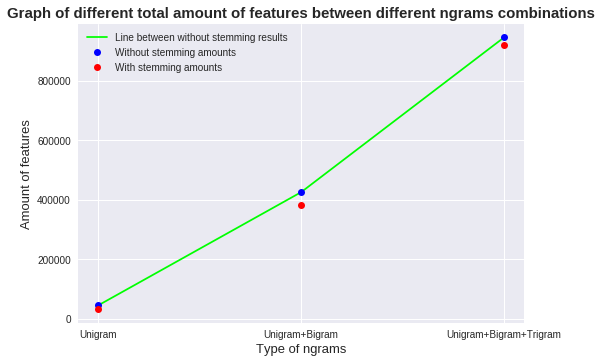

In [120]:
# YOUR CODE HERE
classes = ["POS","NEG"]
neg_reviews =  reviews[0:1000]
pos_reviews = reviews[1000:]
train_set = neg_reviews[:900] + pos_reviews[:900]

nb = NB_classifier(classes,1,False,3)
nb.fit(train_set)
print("Size of unigram vocabulary without stemming: {}".format( len(nb.unigram_voc) ))
print("Size of bigram vocabulary without stemming: {}".format( len(nb.bigram_voc) ))
print("Size of trigram vocabulary without stemming: {}".format( len(nb.trigram_voc) ))
without_stemming = [len(nb.unigram_voc),len(nb.bigram_voc),len(nb.trigram_voc)]

nb = NB_classifier(classes,1,True,3)
nb.fit(train_set)
print("\nSize of unigram vocabulary with stemming: {}".format( len(nb.unigram_voc) ))
print("Size of bigram vocabulary with stemming: {}".format( len(nb.bigram_voc) ))
print("Size of trigram vocabulary with stemming: {}".format( len(nb.trigram_voc) ))
with_stemming = [len(nb.unigram_voc),len(nb.bigram_voc),len(nb.trigram_voc)]

x = [0,1,2]
plt.plot(x,without_stemming,'lime',label="Line between without stemming results")
plt.plot(x,without_stemming,'bo',label="Without stemming amounts")
plt.plot(x,with_stemming,'ro',label="With stemming amounts")
plt.xticks(np.arange(3), ("Unigram","Unigram+Bigram","Unigram+Bigram+Trigram"))
plt.legend()
plt.ylabel('Amount of features',fontsize=13)
plt.xlabel('Type of ngrams',fontsize=13)
title_for_plot = "Graph of different total amount of features between different ngrams combinations"
plt.title(title_for_plot,fontsize=15,fontweight="bold")

#From the plot it can be observed, that the number of features increases linearly with the addition of bigrams and trigrams at each step for both with and without stemming. 
#Furtheremore, with stemming has less amount of features, which makes sense as described earlier in Q3.8

# Support Vector Machines (4pts)


Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM.](http://scikit-learn.org/stable/modules/svm.html) with the default parameters.



#### (Q4.1): Train SVM and compare to Naive Bayes (2pt)

Train an SVM classifier (sklearn.svm.LinearSVC) using your features. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier from (Q3.4) and report the numbers.
Do cross validation and concatenate the predictions from all folds to compute the significance.  Are the results significantly better?



In [134]:
# YOUR CODE HERE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

def get_FeaturesAndTargets(data,include_pos_tag=False,given_vocabulary=None,preference_pos=False):
  targets = [] 
  corpus = []
  desired_pos_tags = ["N","V","J","RB"]
  
  for document in data:
      targets.append(document["sentiment"])
      content = document["content"]
      
      concat_full_text = ""
      for sentence in content:
         for token,pos_tag in sentence:
            if include_pos_tag:
                if not preference_pos:
                  concat_full_text += token + pos_tag + " "
                else:
                   for desired_tag in desired_pos_tags: #The desired tags are like super classes, the pos tags can be JJ for example and still be part of J.
                      if desired_tag in pos_tag:
                        concat_full_text += token + pos_tag + " "
                        break
            else: 
                concat_full_text += token + " " #No need to lower() the token it as in CountVectorizer it already uses that
      corpus.append(concat_full_text)
  
  if given_vocabulary == None:
      vectorizer = CountVectorizer()
      features = vectorizer.fit_transform(corpus)
      vocabulary = vectorizer.vocabulary_ 
  else: 
      vectorizer = CountVectorizer(vocabulary=given_vocabulary)
      features = vectorizer.transform(corpus)
      vocabulary = given_vocabulary
  
  return features,targets,vocabulary

classes = ["POS","NEG"]
neg_reviews =  reviews[0:1000]
pos_reviews = reviews[1000:]
train_set = neg_reviews[:900] + pos_reviews[:900]
test_set = neg_reviews[900:] + pos_reviews[900:]

#Use the same vocabulary to make it fair between the comparison. 
nb = NB_classifier(classes)
nb.fit(train_set)
naive_bayes_vocabulary = nb.unigram_voc

modelSVM = LinearSVC()
SVM_folds_performance, SVM_mean_acc, SVM_cv_results = cross_validation(modelSVM,reviews,10,True,vocabulary = naive_bayes_vocabulary)


print("\nSign test between smoothed unigram from Q3.4 and SVM: p_value =\n", p_value)
p_value = sign_test(uni_smoothing_cv_results, SVM_cv_results)

#document_term_matrix,targets,voc = get_FeaturesAndTargets(train_set,naive_bayes_vocabulary)
#x_train = document_term_matrix
#y_train = targets
#model = LinearSVC()
#model.fit(x_train,y_train)

#from sklearn.metrics import accuracy_score
#x_test,y_test,voc = get_FeaturesAndTargets(test_set,voc)
#y_pred = model.predict(x_test)
#accuracy_score(y_test, y_pred)

Accuracy of fold 1: 81.5
Accuracy of fold 2: 82.0
Accuracy of fold 3: 80.0
Accuracy of fold 4: 86.0
Accuracy of fold 5: 84.0
Accuracy of fold 6: 82.5
Accuracy of fold 7: 85.0
Accuracy of fold 8: 85.5
Accuracy of fold 9: 85.0
Accuracy of fold 10: 81.0
Final performance average: 83.25

Sign test between smoothed unigram from Q3.4 and SVM: p_value =
 0.7712977979137471160722421800
the difference is not significant


### More linguistics

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you. Try to
replicate what Pang et al. were doing:



####(Q4.2) Replace your features with word+POS features, and report performance with the SVM. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significant? Why?  (1pt)


In [135]:
# YOUR CODE HERE
classes = ["POS","NEG"]
neg_reviews =  reviews[0:1000]
pos_reviews = reviews[1000:]
train_set = neg_reviews[:900] + pos_reviews[:900]
test_set = neg_reviews[900:] + pos_reviews[900:]

#Don't have to use same vocabulary, make new one
modelSVM = LinearSVC()
SVM_POS_folds_performance, SVM_POS_mean_acc, SVM_POS_cv_results = cross_validation(modelSVM,reviews,10,True,include_pos_tag=True)

#document_term_matrix,targets,voc = get_FeaturesAndTargets(train_set,True)
#x_train = document_term_matrix
#y_train = targets
#model = LinearSVC()
#model.fit(x_train,y_train)

#from sklearn.metrics import accuracy_score
#x_test,y_test,voc = get_FeaturesAndTargets(test_set,True,voc)
#y_pred = model.predict(x_test)
#accuracy_score(y_test, y_pred)
print("\nSign test between smoothed unigram from Q3.4 and SVM with POS tag: p_value =\n", p_value)
p_value = sign_test(uni_smoothing_cv_results, SVM_POS_cv_results)

print("\nSign test between SVM without POS tag and SVM with POS tag: p_value =\n", p_value)
p_value = sign_test(SVM_smoothing_cv_results, SVM_POS_cv_results)

#It does seem to help as the results seem higher, but the sign test proves that the difference is not significant. 

Accuracy of fold 1: 81.5
Accuracy of fold 2: 82.5
Accuracy of fold 3: 83.5
Accuracy of fold 4: 84.5
Accuracy of fold 5: 83.5
Accuracy of fold 6: 83.5
Accuracy of fold 7: 85.5
Accuracy of fold 8: 86.0
Accuracy of fold 9: 85.5
Accuracy of fold 10: 83.0
Final performance average: 83.9

Sign test between smoothed unigram from Q3.4 and SVM with POS tag: p_value =
 0.4605822651825517471808702509
the difference is not significant

Sign test between SVM without POS tag and SVM with POS tag: p_value =
 0.2932785698870256137209886960
the difference is not significant


#### (Q4.3) Discard all closed-class words from your data (keep only nouns (N*), verbs (V*), adjectives (J*) and adverbs (RB*)), and report performance. Does this help? Do cross validation and concatenate the predictions from all folds to compute the significance. Are the results significantly better than when we don't discard the closed-class words? Why? (1pt)

In [137]:
classes = ["POS","NEG"]
neg_reviews =  reviews[0:1000]
pos_reviews = reviews[1000:]
train_set = neg_reviews[:900] + pos_reviews[:900]
test_set = neg_reviews[900:] + pos_reviews[900:]

modelSVM = LinearSVC()
SVM_closed_POS_folds_performance, SVM_closed_POS_mean_acc, SVM_closed_POS_cv_results = cross_validation(modelSVM,reviews,10,True,include_pos_tag=True,preference_pos=True)

print("\nSign test between smoothed unigram from Q3.4 and SVM with closed POS tag: p_value =\n", p_value)
p_value = sign_test(uni_smoothing_cv_results, SVM_closed_POS_cv_results)

print("\nSign test between SVM without POS tag and SVM with POS tag: p_value =\n", p_value)
p_value = sign_test(SVM_smoothing_cv_results, SVM_closed_POS_cv_results)

print("\nSign test between SVM with all POS tag and SVM with closed POS tag: p_value =\n", p_value)
p_value = sign_test(SVM_POS_cv_results, SVM_closed_POS_cv_results)

#The average accuracy is increased with 10 folds. Probably because the most important information are captured with the closed-class words, while the other are less important and act like noise. 

Accuracy of fold 1: 82.5
Accuracy of fold 2: 84.5
Accuracy of fold 3: 81.5
Accuracy of fold 4: 87.0
Accuracy of fold 5: 84.5
Accuracy of fold 6: 83.0
Accuracy of fold 7: 87.0
Accuracy of fold 8: 82.5
Accuracy of fold 9: 86.5
Accuracy of fold 10: 81.5
Final performance average: 84.05

Sign test between smoothed unigram from Q3.4 and SVM with closed POS tag: p_value =
 0.7712977979137471160722421800
the difference is not significant

Sign test between SVM without POS tag and SVM with POS tag: p_value =
 0.2732177720293096189389068499
the difference is not significant

Sign test between SVM with all POS tag and SVM with closed POS tag: p_value =
 0.7373250398720036864195787185
the difference is not significant


# (Q5) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*Write your answer here in max. 500 words.*

# Submission 


In [0]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Also save your notebook as a Github Gist. Get it by choosing `File -> Save as Github Gist`.  Make sure that the gist has a secret link (not public).
- Check if your answers are all included in the file you submit (e.g. check the Github Gist URL)
- Submit your .ipynb file and link to the Github Gist via *Canvas*. One submission per group. 